## Tensorflow Playground on Butterfly Images

In June 2015, I read an article about tensorflow practiced on butterfly images. Just right after presenting my Master's capstone project which I changed from Neural Networks to Enterprise Architecture. I didn't know Neural Networks were the building block of deep learning or the blog I read is about Deep Learning and Computer Vision.
You can find the article [here](https://www.oreilly.com/learning/a-poet-does-tensorflow) but the author didn't share the dataset plus I would love to practice on my own butterfly images, so I used my images for the below examples.
The author of the article built a classifier on his images. My butterfly images relatively small in size and didn't sorted out into classes, so I will work on them to solve another problem in this example.
Those images are all taken using Canon 100mm macro lense and some of them blurred and some of them are clear shots. In order to solve this problem I would like to look at all those photos exif information and put those info in a csv file and tag each of them blurred or clear then try to build a small model predicting if they are clear or not.

https://www.oreilly.com/learning/tensorflow-for-poets

https://www.oreilly.com/learning/a-poet-does-tensorflow

In [1]:
# Import required libraries for this section

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import cv2                     # OpenCV library for computer vision
from PIL import Image
from tqdm import tqdm
import time 
import exifread
import os
import pandas
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf

for more details about exifread https://pypi.org/project/ExifRead/

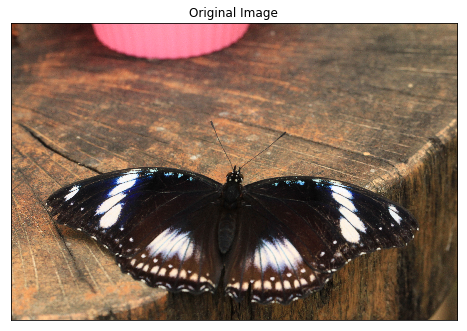

In [2]:
# Load in color image for face detection
path_name = 'data/clear/IMG_6976.JPG'
image = cv2.imread(path_name)

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot our image using subplots to specify a size and title
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

In [3]:
f = open(path_name, 'rb')

# Return Exif tags
tags = exifread.process_file(f)

for tag in tags.keys():
    if tag not in ('JPEGThumbnail', 'TIFFThumbnail', 'Filename', 'EXIF MakerNote'):
         print ("Key: %s, value %s" % (tag, tags[tag]))

Key: Image Make, value Canon
Key: Image Model, value Canon EOS 60D
Key: Image Orientation, value Horizontal (normal)
Key: Image XResolution, value 72
Key: Image YResolution, value 72
Key: Image ResolutionUnit, value Pixels/Inch
Key: Image DateTime, value 2018:10:07 18:19:10
Key: Image Artist, value Aysin TASDELEN
Key: Image YCbCrPositioning, value Co-sited
Key: Image Copyright, value 
Key: Image ExifOffset, value 348
Key: Thumbnail Compression, value JPEG (old-style)
Key: Thumbnail XResolution, value 72
Key: Thumbnail YResolution, value 72
Key: Thumbnail ResolutionUnit, value Pixels/Inch
Key: Thumbnail JPEGInterchangeFormat, value 9156
Key: Thumbnail JPEGInterchangeFormatLength, value 16448
Key: EXIF ExposureTime, value 1/30
Key: EXIF FNumber, value 10
Key: EXIF ExposureProgram, value Aperture Priority
Key: EXIF ISOSpeedRatings, value 1000
Key: EXIF SensitivityType, value Recommended Exposure Index
Key: EXIF RecommendedExposureIndex, value 1000
Key: EXIF ExifVersion, value 0230
Key: EX

Since we want to use exif information to see if it is important for us if the image is clear or blurry we used exifread library to read all the exif information about the image. But, we don't need all of them. The list below is more than enough for our model 
- Key: Image Orientation, value Horizontal (normal)
- Key: Image DateTime, value 2018:10:07 18:19:10
- Key: EXIF ExposureTime, value 1/30
- Key: EXIF FNumber, value 10
- Key: EXIF ExposureProgram, value Aperture Priority
- Key: EXIF ISOSpeedRatings, value 1000
- Key: EXIF ShutterSpeedValue, value 5
- Key: EXIF ApertureValue, value 53/8
- Key: EXIF FocalLength, value 100
- Key: EXIF ExifImageWidth, value 5184
- Key: EXIF ExifImageLength, value 3456
- Key: MakerNote WhiteBalance, value Sunny

We want to learn if any of those exif information is important for our are being blurry or clear, so let's list all images those exif info and their class names and save it in a csv file and use those labels for our prediction models.

In [4]:
tag_keys = [ 'Image Orientation', 'Image DateTime', 'EXIF ExposureTime'
                          ,'EXIF FNumber','EXIF ExposureProgram','EXIF ISOSpeedRatings','EXIF ShutterSpeedValue'
                          ,'EXIF ApertureValue', 'EXIF FocalLength', 'EXIF ExifImageWidth','EXIF ExifImageLength'
                          , 'MakerNote WhiteBalance']
exif_dict = {}
def read_exif(image_path):
    f = open(image_path, 'rb')

    # Return Exif tags
    # we don't need details for faster processing let's send details=false as an argument
    tags = exifread.process_file(f)
    for key in tag_keys:
        exif_dict[key] = tags[key]  
    return exif_dict

In [5]:
#Resize and Rescale images
def resize_rescale(image_path):
    image = cv2.imread(image_path)
    image = color.rgb2gray(image)

    #let's resize our images to imagenet image_size
    image_resized = resize(image, (256, 256),
                       anti_aliasing=True)
    
    return image_resized

In [6]:
def match_features_labels(directory):
    """
    Uncompress features and labels from a zip file
    :param file: The zip file to extract the data from
    """
    features = []
    labels = []
    exifs = []
    
    for root, dirs, files in os.walk(directory):  
        for name in files:
            image_path = os.path.join(root, name)
            exif = read_exif(image_path)
            image = resize_rescale(image_path)
            # Load image data as 1 dimensional array
            # We're using float32 to save on memory space
            feature = np.array(image, dtype=np.float32).flatten()

            # Get the the letter from the filename.  This is the letter of the image.
            label = os.path.split(root)[1]

            features.append(feature)
            labels.append(label)
            exifs.append(exif)
            
    return np.array(features), np.array(labels), np.array(exifs)

# Get the features and labels from the files
all_features, all_labels, all_exifs = match_features_labels('data')

# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False

# Wait until you see that all features and labels have been uncompressed.
print('All features and labels matched.')

/home/ayshine/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


All features and labels matched.


In [ ]:
train_features,test_features,train_labels,test_labels = train_test_split(all_features, all_labels, test_size=0.2)

In [ ]:
# Problem 1 - Implement Min-Max scaling for grayscale image data
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # TODO: Implement Min-Max scaling for grayscale image data
    a = 0.1
    b = 0.9
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

### DON'T MODIFY ANYTHING BELOW ###
# Test Cases
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 255])),
    [0.1, 0.103137254902, 0.106274509804, 0.109411764706, 0.112549019608, 0.11568627451, 0.118823529412, 0.121960784314,
     0.125098039216, 0.128235294118, 0.13137254902, 0.9],
    decimal=3)
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 10, 20, 30, 40, 233, 244, 254,255])),
    [0.1, 0.103137254902, 0.13137254902, 0.162745098039, 0.194117647059, 0.225490196078, 0.830980392157, 0.865490196078,
     0.896862745098, 0.9])

if not is_features_normal:
    train_features = normalize_grayscale(train_features)
    test_features = normalize_grayscale(test_features)
    is_features_normal = True

print('Tests Passed!')

In [ ]:
if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(train_labels)
    train_labels = encoder.transform(train_labels)
    test_labels = encoder.transform(test_labels)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    train_labels = train_labels.astype(np.float32)
    test_labels = test_labels.astype(np.float32)
    is_labels_encod = True

print('Labels One-Hot Encoded')

In [ ]:
assert is_features_normal, 'You skipped the step to normalize the features'
assert is_labels_encod, 'You skipped the step to One-Hot Encode the labels'

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')

In [ ]:
# Save the data for easy access
pickle_file = 'butterfly.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('notMNIST.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

# Train the model

In [ ]:
# All the pixels in the image (28 * 28 = 784)
features_count = 65536
# All the labels
labels_count = 2

# TODO: Set the features and labels tensors
features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)

# TODO: Set the weights and biases tensors
weights = tf.Variable(tf.truncated_normal((features_count, labels_count)))
biases = tf.Variable(tf.zeros(labels_count))


### DON'T MODIFY ANYTHING BELOW ###

#Test Cases
from tensorflow.python.ops.variables import Variable

assert features._op.name.startswith('Placeholder'), 'features must be a placeholder'
assert labels._op.name.startswith('Placeholder'), 'labels must be a placeholder'
assert isinstance(weights, Variable), 'weights must be a TensorFlow variable'
assert isinstance(biases, Variable), 'biases must be a TensorFlow variable'

assert features._shape == None or (\
    features._shape.dims[0].value is None and\
    features._shape.dims[1].value in [None, 65536]), 'The shape of features is incorrect'
assert labels._shape  == None or (\
    labels._shape.dims[0].value is None and\
    labels._shape.dims[1].value in [None, 2]), 'The shape of labels is incorrect'
assert weights._variable._shape == (65536, 2), 'The shape of weights is incorrect'
assert biases._variable._shape == (2), 'The shape of biases is incorrect'

assert features._dtype == tf.float32, 'features must be type float32'
assert labels._dtype == tf.float32, 'labels must be type float32'

# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

# Linear Function WX + b
logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)

# Cross entropy
cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)

# Training loss
loss = tf.reduce_mean(cross_entropy)

# Create an operation that initializes all variables
init = tf.global_variables_initializer()

# Test Cases
with tf.Session() as session:
    session.run(init)
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    session.run(loss, feed_dict=test_feed_dict)
    biases_data = session.run(biases)

assert not np.count_nonzero(biases_data), 'biases must be zeros'

print('Tests Passed!')

In [ ]:
# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Accuracy function created.')

In [ ]:
# Change if you have memory restrictions
batch_size = 128

# TODO: Find the best parameters for each configuration
epochs = 5
learning_rate = 0.4



### DON'T MODIFY ANYTHING BELOW ###
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.3
# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

In [ ]:
 ### DON'T MODIFY ANYTHING BELOW ###
# The accuracy measured against the test set
test_accuracy = 0.3

with tf.Session() as session:
    
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer
            _ = session.run(optimizer, feed_dict={features: batch_features, labels: batch_labels})

        # Check accuracy against Test data
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)


assert test_accuracy >= 0.80, 'Test accuracy at {}, should be equal to or greater than 0.80'.format(test_accuracy)
print('Nice Job! Test Accuracy is {}'.format(test_accuracy))